# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
* [Worker Analysis](#Worker-Analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
		* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

# Submitting HITs

## Building URLs for images on s3

In [2]:
book_groups, ranges = amt_util.load_book_info()

daily_sci_urls = amt_util.make_book_group_urls(book_groups, 'daily_sci', ranges)
spectrum_sci_urls = amt_util.make_book_group_urls(book_groups, 'spectrum_sci', ranges)
read_und_sci_urls  = amt_util.make_book_group_urls(book_groups, 'read_und_sci', ranges)
workbook_urls = amt_util.make_book_group_urls(book_groups, 'workbooks', ranges)
misc_urls = amt_util.make_book_group_urls(book_groups, 'misc', ranges)

In [3]:
len(daily_sci_urls + spectrum_sci_urls)

2031

In [4]:
combined_df_question_pages_only = pd.read_pickle('pages_w_questions.pkl')

In [5]:
pages_w_questions = pd.unique(combined_df_question_pages_only['page'])

In [6]:
question_specific_urls = [url for url in daily_sci_urls if url.split('=')[1].split('&')[0] in pages_w_questions]

In [7]:
len(question_specific_urls)

856

## submitting HITs in groups

In [28]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = sandbox_host,
    debug = 1 # debug = 2 prints out all requests.
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$10,000.00


In [5]:
static_params = {
    'title': "Annotate Science Questions",
    'description': "Choose which category question from a grade-school science book best belongs to",
    'keywords': ['image', 'science', 'text', 'labeling' ],
    'frame_height': 800,
    'amount': 0.06,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 3
}

### creates HITs, careful with this one

In [21]:
pages_to_use = question_specific_urls
# pages_to_use = workbook_urls + misc_urls + read_und_sci_urls
expected_cost = len(pages_to_use) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $154.08


uncomment cell below only when ready to submit

In [24]:
# amt_util.create_hits_from_pages(mturk, pages_to_use, static_params)

## Qualifications

In [34]:
new_qual_name = 'science textbook annotation'
new_qual_description = 'Qualification for workers who have proved to be good at annotating science textbooks'
# my_qual_type = mturk.create_qualification_type(new_qual_name, new_qual_description, status='Active')

my_qual_type = mturk.search_qualification_types(new_qual_name)[0]

In [55]:
my_qual_id = my_qual_type.QualificationTypeId
print my_qual_id

3SR1M7GDJUS2QU502S1PPKCWG30A2B


In [ ]:
mturk.assign_qualification(my_qual_id, worker_id)

# Reviewing HITs

## setting up hits to review

In [6]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [7]:
raw_hit_results_current_batch = amt_util.process_raw_hits(assignment_results_current_batch)

The two commands above interact with mechanical turk and can take a while

In [8]:
results_df_question_batch = amt_util.make_question_results_df(raw_hit_results_current_batch)

In [9]:
results_df_question_batch.shape

(70302, 7)

In [10]:
pd.unique(results_df_question_batch['page']).shape

(856,)

In [14]:
# results_df_question_batch['group_n'] = pd.to_numeric(results_df_question_batch['group_n'])

In [12]:
results_df_question_only = results_df_question_batch[results_df_question_batch['group_n'] != '0']

In [13]:
consensus_results_df_current_batch = amt_util.make_consensus_df(results_df_question_only, 'No Consensus')

In [14]:
no_consensus_hits_cat = consensus_results_df_current_batch[consensus_results_df_current_batch['category'] == 'No Consensus']

flaw_rate = len(no_consensus_hits_cat) / len(consensus_results_df_current_batch)
print 'question boxes without category consensus comprise ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

question boxes without category consensus comprise 11.65% of the total


In [15]:
no_consensus_hits = consensus_results_df_current_batch[consensus_results_df_current_batch['group_n'] == 'No Consensus']

flaw_rate = len(no_consensus_hits) / len(consensus_results_df_current_batch)
print 'question boxes without group consensus comprise ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

question boxes without group consensus comprise 13.00% of the total


## sending to review tool

In [207]:
multi_choice_pages = consensus_results_df_complete[consensus_results_df_complete['category'] == 'Multiple Choice']
pages_to_review =pd.unique(multi_choice_pages['page'])
to_review = ['start_seq'] + pages_to_review.tolist()

In [22]:
# consensus_results_df_complete = amt_util.make_consensus_df(results_df_question_batch, 'No Consensus')
consensus_results_df_complete = combined_consensus_df

In [199]:
amt_util.write_results_df(consensus_results_df_complete, 'annotations-w-questions/' ,'labeled-questions/')

In [26]:
# all pages from the latest batch
pages_to_review =pd.unique(consensus_results_df_complete['page'])
to_review = ['start_seq'] + pages_to_review.tolist()

In [193]:
# all pages from the latest batch with a no-consensus box
# pages_to_review =pd.unique(no_consensus_hits['page'])

In [194]:
pd.Series(to_review[1:]).to_pickle('rev_seq.pkl')

In [78]:
single_page = ['Daily_Science_Grade_2_Evan_Moor_33.jpeg']

In [83]:
problem_pages = pd.read_pickle('problem_pages.pkl').tolist()

In [84]:
to_review = ['start_seq'] + problem_pages

In [81]:
to_review = ['start_seq'] + single_page

In [209]:
suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review)]
# suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(['A3VE5OH94HYHET'])]
amt_util.write_results_df(suspect_subset, 'annotations-w-questions/' ,'labeled-questions2/')
pages_to_review = pd.unique(suspect_subset['page'])

IOError: [Errno 2] No such file or directory: u'/Users/schwenk/wrk/notebooks/stb/ai2-vision-turk-data/textbook-annotation-test/labeled-questions2/Daily_Science_Grade_1_Evan_Moor_101.json'

In [24]:
sampling_rate = 0.5
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

# labeled_quest_dir = 'labeled-questions/'

sampling 428 pages out of 856


In [27]:
anno_dir = 'hierarchy-ext-test/'
anno_dir = 'labeled-questions/'

amt_util.review_results(to_review, anno_dir)

print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [73]:
%%capture 
# all pages from the latest batch with a no-consensus box
suspect_subset = results_df_current_batch[results_df_current_batch['worker_id'].isin(suspect_workers[:5])]
amt_util.write_results_df(suspect_subset)
pages_to_review = pd.unique(suspect_subset['page'])

# Merging latest round of HITs into combined dataset  

## Load prior complete dataset if not in memory

In [17]:
data_pickled_dir = './store_hit_results_metadata/question_anno/group_latest_combined/' 

In [18]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

In [19]:
amt_util.count_pages_in_df(combined_consensus_with_workerid_df)

856

## Updating full dataset

In [15]:
combined_results_df = results_df_question_batch
combined_consensus_df = consensus_results_df_complete
combined_consensus_with_workerid_df = consensus_with_workerid_df

NameError: name 'results_df_question_batch' is not defined

## Working with full dataset

In [16]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

In [964]:
flaw_rate = len(no_consensus_hits) / len(combined_consensus_df)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

text boxes without consensus are 2.94% of the total


In [227]:
worker_quality_df[worker_quality_df['submitted'] > 50].sort_values('flaw_ratio', ascending= True).head(25)

,submitted,incorrect,flaw_ratio
A2HTN7HCNBQ8V4,130.0,2.0,0.015385
A3JOFB6Z65I37Q,124.0,2.0,0.016129
AEWGY34WUIA32,1538.0,40.0,0.026008
ASB8T0H7L99RF,507.0,14.0,0.027613
AMA18W8F60Y2J,100.0,3.0,0.030000
A2YY1ZR7Z4VT4M,1517.0,54.0,0.035597
AJFVK3O1D7SPE,1114.0,41.0,0.036804
A1S8DYWNS59XWB,728.0,28.0,0.038462
AJ7D7M9EHDQCL,489.0,19.0,0.038855
A2PEIHMPPOB1YJ,641.0,25.0,0.039002


In [205]:
bad_and_prolific_workers[:15]

,submitted,incorrect,flaw_ratio
A2KM2RWXQV47CV,2900.0,2093.0,0.721724
A16EEWCUQK9LM2,1069.0,446.0,0.417212
A1QZHZZMO2TE51,582.0,215.0,0.369416
A2XJH3WC02RMXQ,134.0,87.0,0.649254
AQE7EQDM98KB7,154.0,47.0,0.305195
A18DRAESIN3E94,112.0,43.0,0.383929
A8TDOYC7FWWKR,67.0,36.0,0.537313
A9Y1HKUEOOEPM,49.0,35.0,0.714286
A1EGJ4WHHIU61V,45.0,24.0,0.533333
A1ESKJFDQUMBL4,68.0,23.0,0.338235


After looking through the top few offenders, it's clear that 

1. the very worst intentionally submitted many blank pages

2. the rest didn't read the directions very closely

3. I'm comfortable rejecting the work of those with > 100 submissions

4. I'll ban the worst 15 from future HITs


In [49]:
amt_util.write_results_df(combined_consensus_df)

In [45]:
# all pages from the complete
pages_to_review =pd.unique(combined_consensus_df['page'])

In [165]:
# all pages from the complete dataset with a no-consensus box
pages_to_review =pd.unique(no_consensus_hits['page'])

In [208]:
%%capture 
# all pages from the latest batch with a no-consensus box
suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review[10:15])]
amt_util.write_results_df(suspect_subset)
pages_to_review = pd.unique(suspect_subset['page'])

In [50]:
sampling_rate = 0.2
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 404 pages out of 2022


In [51]:
amt_util.review_results(to_review)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


# Worker Analysis

## Basic worker stats

In [19]:
consensus_with_workerid_df = amt_util.make_consensus_df_w_worker_id(combined_results_df, consensus_results_df_complete)

In [21]:
print 'number of unique workers:'
pd.unique(combined_results_df['worker_id']).shape[0]

number of unique workers:


72

In [118]:
# _ = combined_results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [92]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [93]:
task_duration_series = pd.Series(task_duration_seconds)

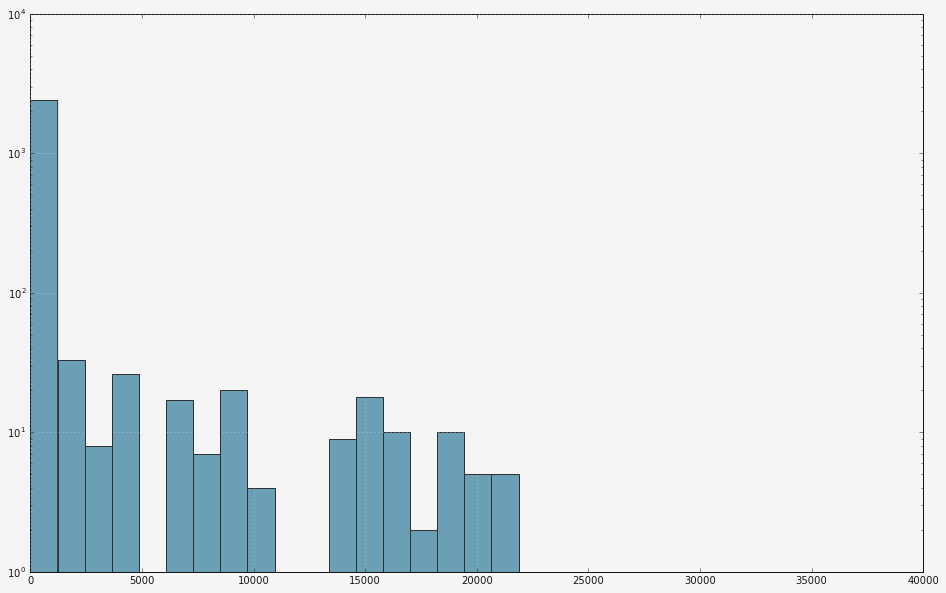

In [94]:
_ = task_duration_series.hist(bins=30, log=True)

In [97]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

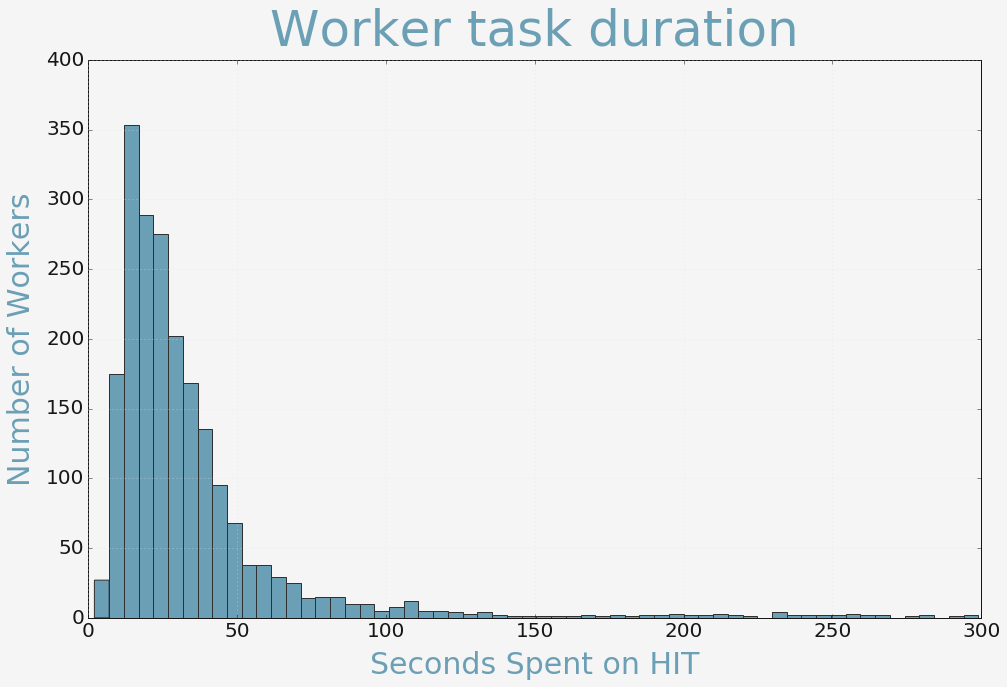

In [98]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [99]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 14
duration median= 25.0


### Identifying high and low consensus workers

In [100]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

,submitted,incorrect,flaw_ratio
A2F0NZQ8F9ON8C,141.0,1.0,0.007092
A2PEIHMPPOB1YJ,451.0,12.0,0.026608
A3KKRE2IS3AF3I,221.0,6.0,0.027149
A3RS7UCO7CQ74R,111.0,4.0,0.036036
AEWGY34WUIA32,55.0,2.0,0.036364
A1XRIEYLA7ZJ3B,296.0,12.0,0.040541
A24NXYAW8T2JA0,241.0,11.0,0.045643
A3UYK0Z6ZHS7I4,21.0,1.0,0.047619
A1BBC4UHXDI434,810.0,49.0,0.060494
A3857424R8YR3Y,306.0,22.0,0.071895


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [66]:
# aw_set = set(all_worker_counts.index)
# bw_set = set(bad_worker_counts.index)
# flawless_workers = list(aw_set.difference(bw_set))
# all_worker_counts[all_worker_counts.index.isin(best_workers)]

In [107]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [112]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:5].index)

In [111]:
bad_and_prolific_workers.head(15)

,submitted,incorrect,flaw_ratio
A1E56264OK9UN5,1868.0,668.0,0.357602
A3GNQDFPZALU92,2013.0,285.0,0.141580
A35IEM9AICHLN0,1238.0,162.0,0.130856
A3UUH3632AI3ZX,537.0,79.0,0.147114
A2IJ30JVZYDJ20,82.0,54.0,0.658537
A24JLI0VZP59WK,156.0,50.0,0.320513
A4T1X0PO5N1G9,276.0,38.0,0.137681
A1HBGAN6P9PCJW,67.0,38.0,0.567164
A31KR6QG24K19O,152.0,26.0,0.171053
A1GKTC682SWY23,54.0,19.0,0.351852


In [122]:
def reject_bad_assignments(rejected_assignment_ids, rejected_worker_ids):
    for assignment in rejected_assignment_ids:
        mturk.reject_assignment(assignment)
        
        rejection_message_subject = "One of your HITs was rejected"
        
        rejection_message = """
        Your HIT was rejected because it was either incomplete or largely incorrect.
        """
        
        mturk.notify_workers(rejected_worker_ids, rejection_message_subject, rejection_message)

## Messaging workers

In [889]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
I've added some additional instructions, and have removed the default instruction page (they can still be accessed by Read
Instruction Button).

Happy to get any feedback you might have for the new HITs.
"""

In [693]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

# HIT end-of-life

## Pickle latest results

In [61]:
#reset as needed
# gn = 1

In [60]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/question_anno/group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(results_df_question_batch, temp_store_dir + group_n + raw_results_file_name)
results_df_current_batch.to_pickle(temp_store_dir + group_n + complete_results_file)
consensus_results_df_current_batch.to_pickle(temp_store_dir + group_n + consensus_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 1
now onto batch 2


## Pickle combined dataset

In [110]:
temp_store_dir = './store_hit_results_metadata/question_anno/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

In [155]:
workers_to_ban = bad_and_prolific_workers[:2].index.tolist()

In [156]:
workers_to_ban

[u'A1E56264OK9UN5', u'A3GNQDFPZALU92']

In [157]:
number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

rejecting 132 assignments from 2 workers


In [174]:
# assignments_to_accept = []
assignment_status = []
for hit_id, assignments in assignment_results_after_rejects.items():
    for assignment in assignments:
        assignment_status.append(assignment.AssignmentStatus)
        if assignment.AssignmentStatus == 'Submitted':
            assignments_to_accept.append(assignment)
status_series = pd.Series(assignment_status)

In [182]:
r_hits_after_rejects = amt_util.get_completed_hits(mturk)

In [183]:
assignment_results_after_rejects = amt_util.get_assignments(mturk, r_hits_after_rejects)

In [184]:
# amt_util.accept_hits(mturk, assignment_results_after_rejects)

In [31]:
# amt_util.delete_all_hits(mturk)